In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

### Extracting Churn Members and Non Churn Members for April 2025

In [14]:
query = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        'April' AS month_label,
        CASE
            WHEN m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST' THEN 1
            WHEN m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date' THEN 0
            ELSE NULL
        END AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE (
        (m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date') OR
        (m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST')
    )
      AND e.event_value BETWEEN '2025-04-01' AND '2025-04-30'
      """

data1 = client.query(query).to_dataframe()

In [15]:
data1
print(data1.shape)
print(data1.isnull().sum())
print(data1['churn'].value_counts())

,owner_mbr_nbr,mbr_nbr,mbr_type,mbr_mbrshp_type_cd,event_type,event_value,event_month,month_label,churn
0,500353,500353,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-15 14:12:11+00:00,2025-04-01 00:00:00+00:00,April,0
1,177689,177689,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-01 08:02:49+00:00,2025-04-01 00:00:00+00:00,April,0
2,198144,198144,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-17 18:40:20+00:00,2025-04-01 00:00:00+00:00,April,0
3,200260,200260,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-03 08:05:22+00:00,2025-04-01 00:00:00+00:00,April,0
4,227111,227111,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-29 13:15:56+00:00,2025-04-01 00:00:00+00:00,April,0
...,...,...,...,...,...,...,...,...,...
6394,512999,512999,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-01 10:00:13+00:00,2025-04-01 00:00:00+00:00,April,1
6395,510211,510211,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-01 10:00:15+00:00,2025-04-01 00:00:00+00:00,April,1
6396,512613,512613,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-01 10:00:13+00:00,2025-04-01 00:00:00+00:00,April,1
6397,516851,516851,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-02 10:00:03+00:00,2025-04-01 00:00:00+00:00,April,1


(6399, 9)
owner_mbr_nbr         0
mbr_nbr               0
mbr_type              0
mbr_mbrshp_type_cd    0
event_type            0
event_value           0
event_month           0
month_label           0
churn                 0
dtype: int64
churn
1    3966
0    2433
Name: count, dtype: Int64


* Below query extracts unique owner mbr from above and converts into SQL IN clause format

In [16]:
owner_ids = data1['owner_mbr_nbr'].unique().tolist()
owner_ids_str = ", ".join([str(x) for x in owner_ids])

In [23]:
churn_list = data1[data1['churn'] == 1]['owner_mbr_nbr'].unique().tolist()

In [17]:
len(owner_ids)

6381

* Below query extracts PMs (churn /non-churn in April) and their data between oct 2024 - mar 2025 excluding CDS

In [124]:
query = f"""
    WITH lot_fact_filtered AS (
      SELECT lot_nbr, inv_dt, seller_parent_company, high_bid_amt, buyer_nbr
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
      WHERE inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
        AND seller_parent_company != 'CDS'
    ),

    member_info AS (
      SELECT owner_mbr_nbr, mbr_nbr, mbr_state, mbr_country, member_sgmnt_type
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
        WHERE owner_mbr_nbr IN ({owner_ids_str})
    ),

    bids_placed AS (
      SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_state,
        m.mbr_country,
        m.member_sgmnt_type,
        avg(b.max_bid_amt) AS avg_max_bid_amt,
        COUNTIF(l.inv_dt IS NOT NULL) AS total_bids_on_lots_sold
      FROM member_info m
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
        ON m.mbr_nbr = b.buyer_nbr
      LEFT JOIN lot_fact_filtered l
        ON b.lot_nbr = l.lot_nbr
      GROUP BY m.owner_mbr_nbr, m.mbr_nbr, m.mbr_state, m.mbr_country, m.member_sgmnt_type
    ),

    lots_bid_on AS (
      SELECT
        b.buyer_nbr AS mbr_nbr,
        COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
      JOIN lot_fact_filtered l
        ON b.lot_nbr = l.lot_nbr
      GROUP BY b.buyer_nbr
    ),

    lots_won AS (
      SELECT
        l.buyer_nbr AS mbr_nbr,
        AVG(l.high_bid_amt) AS AvgSellingPrice,
        COUNT(DISTINCT l.lot_nbr) AS total_lots_won
      FROM lot_fact_filtered l
      GROUP BY l.buyer_nbr
    )

    SELECT
      bp.owner_mbr_nbr,
      bp.mbr_nbr,
      bp.total_bids_on_lots_sold,
      lb.total_lots_placed_bids_on,
      w.total_lots_won,
      bp.avg_max_bid_amt,
      w.AvgSellingPrice,
      bp.mbr_state,
      bp.mbr_country,
      bp.member_sgmnt_type
    FROM bids_placed bp
    LEFT JOIN lots_bid_on lb ON bp.mbr_nbr = lb.mbr_nbr
    LEFT JOIN lots_won w ON bp.mbr_nbr = w.mbr_nbr
    """
    # Run the query
data2 = client.query(query).to_dataframe()

In [125]:
data2
print(data2.shape)
print(data2.isnull().sum())
print(data2['owner_mbr_nbr'].nunique())

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type
0,94054,94054,0,<NA>,<NA>,NaN,NaN,FL,USA,Consumer
1,502939,502939,0,<NA>,<NA>,19171.428571,NaN,TX,USA,Consumer
2,569911,569911,419,103,27,2645.905622,2487.962963,KY,USA,Dealer
3,856923,856923,124,18,2,2389.041096,4300.000000,NJ,USA,General Business
4,859708,859708,79,11,2,9880.600649,13200.000000,KN,KNA,Exporter
...,...,...,...,...,...,...,...,...,...,...
6376,648271,648271,0,<NA>,<NA>,2229.787234,NaN,AZ,USA,Consumer
6377,721113,721113,23,3,<NA>,1766.546645,NaN,PA,USA,Consumer
6378,843372,843372,0,<NA>,<NA>,7007.881773,NaN,NY,USA,Dealer
6379,364375,364375,11,3,<NA>,1804.789474,NaN,LA,USA,Consumer


(6381, 10)
owner_mbr_nbr                   0
mbr_nbr                         0
total_bids_on_lots_sold         0
total_lots_placed_bids_on    3159
total_lots_won               4162
avg_max_bid_amt               833
AvgSellingPrice              4162
mbr_state                       0
mbr_country                     0
member_sgmnt_type             341
dtype: int64
6381


In [126]:
data2_copy = data2.copy()

In [127]:
data2_copy['churn'] = data2_copy['owner_mbr_nbr'].isin(churn_list).astype(int)

In [128]:
data2_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn
0,94054,94054,0,<NA>,<NA>,NaN,NaN,FL,USA,Consumer,1
1,502939,502939,0,<NA>,<NA>,19171.428571,NaN,TX,USA,Consumer,1
2,569911,569911,419,103,27,2645.905622,2487.962963,KY,USA,Dealer,0
3,856923,856923,124,18,2,2389.041096,4300.000000,NJ,USA,General Business,0
4,859708,859708,79,11,2,9880.600649,13200.000000,KN,KNA,Exporter,0
...,...,...,...,...,...,...,...,...,...,...,...
6376,648271,648271,0,<NA>,<NA>,2229.787234,NaN,AZ,USA,Consumer,0
6377,721113,721113,23,3,<NA>,1766.546645,NaN,PA,USA,Consumer,1
6378,843372,843372,0,<NA>,<NA>,7007.881773,NaN,NY,USA,Dealer,0
6379,364375,364375,11,3,<NA>,1804.789474,NaN,LA,USA,Consumer,0


In [129]:
data2_copy['churn'].value_counts()

churn
1    3948
0    2433
Name: count, dtype: int64

In [130]:
data2_copy['owner_mbr_nbr'].nunique()

6381

In [131]:
data2_copy['winning_perc'] = np.round((data2_copy['total_lots_won'] / data2_copy['total_lots_placed_bids_on'])*100,2)

In [132]:
data2_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
0,94054,94054,0,<NA>,<NA>,NaN,NaN,FL,USA,Consumer,1,<NA>
1,502939,502939,0,<NA>,<NA>,19171.428571,NaN,TX,USA,Consumer,1,<NA>
2,569911,569911,419,103,27,2645.905622,2487.962963,KY,USA,Dealer,0,26.21
3,856923,856923,124,18,2,2389.041096,4300.000000,NJ,USA,General Business,0,11.11
4,859708,859708,79,11,2,9880.600649,13200.000000,KN,KNA,Exporter,0,18.18
...,...,...,...,...,...,...,...,...,...,...,...,...
6376,648271,648271,0,<NA>,<NA>,2229.787234,NaN,AZ,USA,Consumer,0,<NA>
6377,721113,721113,23,3,<NA>,1766.546645,NaN,PA,USA,Consumer,1,<NA>
6378,843372,843372,0,<NA>,<NA>,7007.881773,NaN,NY,USA,Dealer,0,<NA>
6379,364375,364375,11,3,<NA>,1804.789474,NaN,LA,USA,Consumer,0,<NA>


<Axes: ylabel='Frequency'>

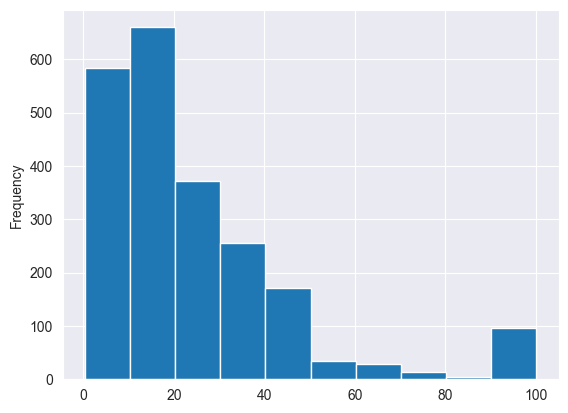

In [133]:
data2_copy['winning_perc'].plot(kind='hist')

In [134]:
filtered_df = data2_copy[(data2_copy['winning_perc'] <= 20) & (data2_copy['mbr_country'] == 'USA')]
filtered_df

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
3,856923,856923,124,18,2,2389.041096,4300.000000,NJ,USA,General Business,0,11.11
7,105335,105335,1567,255,29,5722.187640,7609.482759,MO,USA,Dismantler,0,11.37
14,598718,598718,135,26,2,1756.465517,1700.000000,PA,USA,Consumer,0,7.69
20,319935,319935,52,16,1,2155.530504,725.000000,NC,USA,Consumer,1,6.25
24,872,872,1202,326,22,2106.849977,1765.909091,NC,USA,Dealer,1,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...
6353,590960,590960,79,11,2,3362.336066,2775.000000,WI,USA,Dealer,0,18.18
6354,458973,458973,998,197,19,5412.439382,4885.526316,MI,USA,Dismantler,0,9.64
6361,109526,109526,168,24,1,2169.105675,21500.000000,NC,USA,Dealer,1,4.17
6369,545664,545664,246,37,3,4352.039441,2300.000000,TX,USA,Dealer,0,8.11


In [135]:
filtered_df[filtered_df['owner_mbr_nbr']==611334]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
272,611334,611334,195,56,4,11312.153518,9925.0,MI,USA,Consumer,1,7.14


* User 611334 has winning % of 7% and churned. He placed bids on 56 different lots. Analyze the other bidders on those lots

In [77]:
query3 = """
WITH target_lots AS (
  SELECT DISTINCT b.lot_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON b.lot_nbr = l.lot_nbr
  WHERE b.buyer_nbr = 611334
    AND l.inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
    AND l.seller_parent_company != 'CDS'
),

-- Step 2: Find all bids on those 8 lots by other buyers
other_bidders AS (
  SELECT
    b.lot_nbr,
    b.buyer_nbr,
    b.bid_amt,
    b.bid_dttm
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN target_lots tl
    ON b.lot_nbr = tl.lot_nbr
  WHERE b.buyer_nbr != 611334
)

-- Step 3: Optionally join member info for those other buyers
SELECT
  ob.lot_nbr,
  ob.buyer_nbr,
  m.owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  ob.bid_amt,
  ob.bid_dttm
FROM other_bidders ob
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  ON ob.buyer_nbr = m.mbr_nbr
ORDER BY ob.lot_nbr, ob.bid_amt DESC
"""

data3 = client.query(query3).to_dataframe()

In [78]:
data3

,lot_nbr,buyer_nbr,owner_mbr_nbr,mbr_state,member_sgmnt_type,bid_amt,bid_dttm
0,42130455,192708,192708,MI,Consumer,5000.0,2025-03-25 20:42:12+00:00
1,42130455,425043,307147,FL,Dismantler,5000.0,2025-03-13 15:30:57+00:00
2,42130455,293426,293426,MI,Dealer,4950.0,2025-03-13 15:30:51+00:00
3,42130455,425043,307147,FL,Dismantler,4900.0,2025-03-13 15:30:44+00:00
4,42130455,293426,293426,MI,Dealer,4850.0,2025-03-13 15:30:38+00:00
...,...,...,...,...,...,...,...
6461,89085585,307443,774468,TN,Dismantler,2200.0,2025-02-10 19:39:57+00:00
6462,89085585,114154,114154,MI,Dismantler,2150.0,2025-02-10 19:39:57+00:00
6463,89085585,307443,774468,TN,Dismantler,225.0,2025-02-05 12:20:59+00:00
6464,89085585,852526,336343,IL,Dismantler,200.0,2025-02-03 20:31:12+00:00


In [79]:
mbr_lst = data3['owner_mbr_nbr'].unique().tolist()

In [81]:
print("There were ",len(mbr_lst)," other bidders on the lots where user 611334 placed bids.")

There were  725  other bidders on the lots where user 611334 placed bids.


* Including all members regardless of event type in churn, not-churn for Oct - March

In [137]:
query4 = f"""
    WITH lot_fact_filtered AS (
      SELECT lot_nbr, inv_dt, seller_parent_company, high_bid_amt, buyer_nbr
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
      WHERE inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
        AND seller_parent_company != 'CDS'
    ),

    member_info AS (
      SELECT owner_mbr_nbr, mbr_nbr, mbr_state, mbr_country, member_sgmnt_type
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
    ),

    bids_placed AS (
      SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_state,
        m.mbr_country,
        m.member_sgmnt_type,
        avg(b.bid_amt) AS avg_max_bid_amt,
        COUNTIF(l.inv_dt IS NOT NULL) AS total_bids_on_lots_sold
      FROM member_info m
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
        ON m.mbr_nbr = b.buyer_nbr
      LEFT JOIN lot_fact_filtered l
        ON b.lot_nbr = l.lot_nbr
      GROUP BY m.owner_mbr_nbr, m.mbr_nbr, m.mbr_state, m.mbr_country, m.member_sgmnt_type
    ),

    lots_bid_on AS (
      SELECT
        b.buyer_nbr AS mbr_nbr,
        COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
      JOIN lot_fact_filtered l
        ON b.lot_nbr = l.lot_nbr
      GROUP BY b.buyer_nbr
    ),

    lots_won AS (
      SELECT
        l.buyer_nbr AS mbr_nbr,
        AVG(l.high_bid_amt) AS AvgSellingPrice,
        COUNT(DISTINCT l.lot_nbr) AS total_lots_won
      FROM lot_fact_filtered l
      GROUP BY l.buyer_nbr
    )

    SELECT
      bp.owner_mbr_nbr,
      bp.mbr_nbr,
      bp.total_bids_on_lots_sold,
      lb.total_lots_placed_bids_on,
      w.total_lots_won,
      bp.avg_max_bid_amt,
      w.AvgSellingPrice,
      bp.mbr_state,
      bp.mbr_country,
      bp.member_sgmnt_type
    FROM bids_placed bp
    LEFT JOIN lots_bid_on lb ON bp.mbr_nbr = lb.mbr_nbr
    LEFT JOIN lots_won w ON bp.mbr_nbr = w.mbr_nbr
    """
    # Run the query
data4 = client.query(query4).to_dataframe()

In [138]:
data4

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type
0,1068364624535310336,1068364624535310336,0,<NA>,<NA>,NaN,NaN,None,None,None
1,775815531188916224,775815531188916224,0,<NA>,<NA>,NaN,NaN,None,None,None
2,782944811673030656,782944811673030656,0,<NA>,<NA>,NaN,NaN,None,None,None
3,938150854593093632,938150854593093632,0,<NA>,<NA>,NaN,NaN,None,None,None
4,1253042399386238976,1253042399386238976,0,<NA>,<NA>,NaN,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...
12747388,1349561595793117184,1349561595793117184,0,<NA>,<NA>,NaN,NaN,None,None,None
12747389,768059562751746048,768059562751746048,0,<NA>,<NA>,NaN,NaN,NG,NGA,None
12747390,1239355963256094720,1239355963256094720,0,<NA>,<NA>,NaN,NaN,None,None,None
12747391,1391197256977010688,1391197256977010688,0,<NA>,<NA>,NaN,NaN,None,None,None


In [139]:
data4_copy = data4.copy()

In [140]:
data4_copy['winning_perc'] = np.round((data4_copy['total_lots_won'] / data4_copy['total_lots_placed_bids_on'])*100,2)

In [141]:
data4_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,winning_perc
0,1068364624535310336,1068364624535310336,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
1,775815531188916224,775815531188916224,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
2,782944811673030656,782944811673030656,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
3,938150854593093632,938150854593093632,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
4,1253042399386238976,1253042399386238976,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
12747388,1349561595793117184,1349561595793117184,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
12747389,768059562751746048,768059562751746048,0,<NA>,<NA>,NaN,NaN,NG,NGA,None,<NA>
12747390,1239355963256094720,1239355963256094720,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>
12747391,1391197256977010688,1391197256977010688,0,<NA>,<NA>,NaN,NaN,None,None,None,<NA>


In [142]:
user_611334 = data4_copy[data4_copy['owner_mbr_nbr'].isin(mbr_lst)]
user_611334

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,winning_perc
1105,388238,718365,98,21,2,5794.539889,6900.000000,OR,USA,Dismantler,9.52
1426,307147,879110,0,<NA>,<NA>,3769.387755,NaN,FL,USA,Dismantler,<NA>
1931,461837,602169,314,51,8,5539.569707,6287.500000,GE,GEO,Exporter,15.69
2684,191657,299970,0,<NA>,<NA>,3141.680881,NaN,FL,USA,Dealer,<NA>
5371,531689,578109,1053,321,18,4748.251342,2183.333333,UE,ARE,Exporter,5.61
...,...,...,...,...,...,...,...,...,...,...,...
12744863,461837,677218,848,109,1,1666.153513,2900.000000,GE,GEO,None,0.92
12745147,191657,164272,0,<NA>,<NA>,1119.535696,NaN,FL,USA,Dealer,<NA>
12745301,336343,542895,3,1,<NA>,4924.982960,NaN,IL,USA,Dismantler,<NA>
12745623,307147,771370,0,<NA>,<NA>,4380.513208,NaN,FL,USA,Dismantler,<NA>


In [149]:
user_611334['owner_mbr_nbr'].nunique()

725

<Axes: >

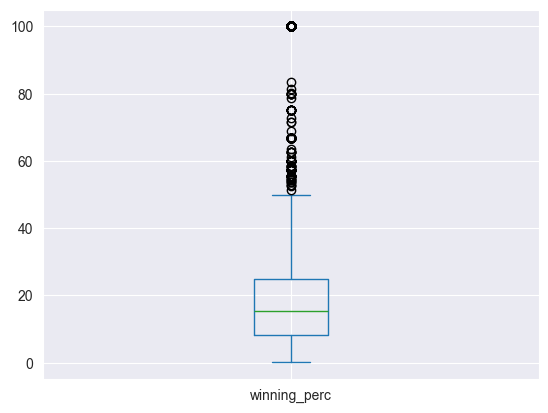

In [143]:
user_611334['winning_perc'].plot(kind='box')

<Axes: ylabel='Frequency'>

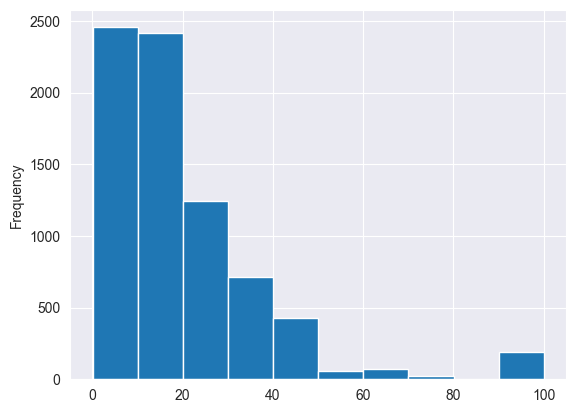

In [144]:
user_611334['winning_perc'].plot(kind='hist')

In [146]:
np.mean(user_611334['avg_max_bid_amt'])

np.float64(5878.464691275715)

In [147]:
np.mean(user_611334['AvgSellingPrice'])

np.float64(7165.194264223909)

In [150]:
np.mean(user_611334['winning_perc'])

np.float64(20.62716598657365)

In [148]:
# Total count
total_count = user_611334['winning_perc'].count()

# Count where winning_perc > 7
greater_than_7_count = user_611334[user_611334['winning_perc'] > 7].shape[0]

# Percentage
percentage = (greater_than_7_count / total_count) * 100

print(f"{percentage:.2f}% of members have winning_perc > 7% on the lots where user 611334 placed bids.")


80.68% of members have winning_perc > 7% on the lots where user 611334 placed bids.


In [151]:
data2_copy[(data2_copy['winning_perc'] >= 20) & (data2_copy['mbr_country'] == 'USA')]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
2,569911,569911,419,103,27,2645.905622,2487.962963,KY,USA,Dealer,0,26.21
6,644723,644723,1304,327,83,3031.704400,3576.506024,TX,USA,Dismantler,0,25.38
11,593627,593627,1,1,1,2325.420077,2950.000000,MN,USA,Dismantler,0,100.0
21,794592,794592,348,61,32,6846.970346,7038.281250,FL,USA,Dealer,0,52.46
29,519980,519980,2519,481,127,2368.783724,2144.291339,MI,USA,Dealer,0,26.4
...,...,...,...,...,...,...,...,...,...,...,...,...
6332,52633,52633,24,1,1,3540.566038,4050.000000,NC,USA,Consumer,0,100.0
6334,556022,556022,20,2,1,1554.296375,5100.000000,TN,USA,Consumer,1,50.0
6343,804482,804482,34,8,4,2350.326797,3200.000000,NY,USA,Dealer,0,50.0
6364,177087,177087,76,14,4,5830.124373,9681.250000,NC,USA,Dealer,1,28.57


* Second example

In [152]:
data2_copy[(data2_copy['winning_perc'] <= 20) & (data2_copy['mbr_country'] == 'USA')]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
3,856923,856923,124,18,2,2389.041096,4300.000000,NJ,USA,General Business,0,11.11
7,105335,105335,1567,255,29,5722.187640,7609.482759,MO,USA,Dismantler,0,11.37
14,598718,598718,135,26,2,1756.465517,1700.000000,PA,USA,Consumer,0,7.69
20,319935,319935,52,16,1,2155.530504,725.000000,NC,USA,Consumer,1,6.25
24,872,872,1202,326,22,2106.849977,1765.909091,NC,USA,Dealer,1,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...
6353,590960,590960,79,11,2,3362.336066,2775.000000,WI,USA,Dealer,0,18.18
6354,458973,458973,998,197,19,5412.439382,4885.526316,MI,USA,Dismantler,0,9.64
6361,109526,109526,168,24,1,2169.105675,21500.000000,NC,USA,Dealer,1,4.17
6369,545664,545664,246,37,3,4352.039441,2300.000000,TX,USA,Dealer,0,8.11


In [157]:
filtered_df_1 = data2_copy[(data2_copy['winning_perc'] <= 20) & (data2_copy['mbr_country'] == 'USA')]
filtered_df_1[filtered_df_1['owner_mbr_nbr'] == 508800]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
5244,508800,508800,5107,1667,329,328.716048,287.993921,AL,USA,Dismantler,0,19.74


In [158]:
query5 = """
WITH target_lots AS (
  SELECT DISTINCT b.lot_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON b.lot_nbr = l.lot_nbr
  WHERE b.buyer_nbr = 508800
    AND l.inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
    AND l.seller_parent_company != 'CDS'
),

-- Step 2: Find all bids on those 8 lots by other buyers
other_bidders AS (
  SELECT
    b.lot_nbr,
    b.buyer_nbr,
    b.bid_amt,
    b.bid_dttm
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN target_lots tl
    ON b.lot_nbr = tl.lot_nbr
  WHERE b.buyer_nbr != 508800
)

-- Step 3: Optionally join member info for those other buyers
SELECT
  ob.lot_nbr,
  ob.buyer_nbr,
  m.owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  ob.bid_amt,
  ob.bid_dttm
FROM other_bidders ob
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  ON ob.buyer_nbr = m.mbr_nbr
ORDER BY ob.lot_nbr, ob.bid_amt DESC
"""

data5 = client.query(query5).to_dataframe()

In [159]:
data5_copy = data5.copy()

In [164]:
mbr_lst_1 = data5_copy['owner_mbr_nbr'].unique().tolist()
user_508800 = data4_copy[data4_copy['owner_mbr_nbr'].isin(mbr_lst_1)]
user_508800

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,winning_perc
1105,388238,718365,98,21,2,5794.539889,6900.000000,OR,USA,Dismantler,9.52
1931,461837,602169,314,51,8,5539.569707,6287.500000,GE,GEO,Exporter,15.69
2263,219230,219230,4794,861,174,6279.838287,5244.540230,AL,USA,Dismantler,20.21
3639,603094,603094,1059,291,34,1002.202625,579.411765,AL,USA,Dismantler,11.68
5371,531689,578109,1053,321,18,4748.251342,2183.333333,UE,ARE,Exporter,5.61
...,...,...,...,...,...,...,...,...,...,...,...
12744324,271092,973832,0,<NA>,<NA>,25544.637097,NaN,MN,USA,Dismantler,<NA>
12744665,388238,804173,101,9,2,5189.206471,8150.000000,OR,USA,Dismantler,22.22
12744863,461837,677218,848,109,1,1666.153513,2900.000000,GE,GEO,None,0.92
12745301,336343,542895,3,1,<NA>,4924.982960,NaN,IL,USA,Dismantler,<NA>


In [166]:
user_508800['owner_mbr_nbr'].nunique()

709

In [167]:
np.mean(user_508800['avg_max_bid_amt'])
np.mean(user_508800['AvgSellingPrice'])
np.mean(user_508800['winning_perc'])

np.float64(5693.065828225399)

np.float64(6692.24823007662)

np.float64(20.23868090633562)

In [169]:
# Total count
total_count = user_508800['winning_perc'].count()

# Count where winning_perc > 7
greater_than_7_count = user_508800[user_508800['winning_perc'] > 20].shape[0]

# Percentage
percentage = (greater_than_7_count / total_count) * 100

print(f"{percentage:.2f}% of members have winning_perc > 20% on the lots where user 611334 placed bids.")


35.30% of members have winning_perc > 20% on the lots where user 611334 placed bids.
